In [1]:
import re
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
from numpy.random import beta, binomial, dirichlet

In [82]:
def tic():
    global start_time
    start_time = time.time()

def toc():
    if 'start_time' in globals():
        elapsed_time = time.time() - start_time
        print("Elapsed time:", elapsed_time, "seconds")
    else:
        print("Toc: start_time not set")
    return elapsed_time

In [83]:
def read_data(path='./spam-or-ham.txt'):
    fp = open(path, 'r', encoding='utf-8')
    texts = []
    labels = []
    for line in fp:
        line = line.strip()
        if line:
            label, text = line.split('\t')
            labels.append(label)
            texts.append(text)
    fp.close()
    # print(texts)    
    return texts, labels

In [84]:
texts, labels = read_data()

In [85]:
def get_freqs(texts):
    freq = {}
    W_mapping = {}
    for text in texts:
        for word in text.split():
            temp_word = re.sub(r'\W+','', word)
            temp_word = temp_word.lower()
            if (temp_word in freq):
                freq[temp_word] += 1
            else:
                freq[temp_word] = 1
    mp=0
    
    freq = dict(sorted(freq.items(), key=lambda item: item[1], reverse=True))
    freq[''] = 0 #We dont want empty strings as words in our data
    freq = dict(sorted(freq.items(), key=lambda item: item[1], reverse=True))
    
    W_freqs = []
    for word in islice(freq.keys(), 10000):
        W_mapping[word] = mp
        mp += 1

    for text in texts:
        temp_freq = {}  
        for word in text.split():
            temp_word = re.sub(r'\W+','', word)
            temp_word = temp_word.lower()
            if (temp_word in W_mapping.keys() and W_mapping[temp_word] in temp_freq):
                temp_freq[W_mapping[temp_word]] += 1
            elif(temp_word in W_mapping.keys()):
                temp_freq[W_mapping[temp_word]] = 1
        W_freqs.append(temp_freq)
    return W_freqs, W_mapping

In [86]:
W_freqs, W_mapping = get_freqs(texts)

In [87]:
no_of_mails = len(W_freqs)
p = 0.3
n = (int)(p*no_of_mails)
#INITIALIZE
def initialize(W_freqs, W_mapping):
    
    known_labels = np.array([0 if x=="ham" else 1 for x in labels[:n]])
    vocab = len(W_mapping)

    #HYPERPARAMETERS
    gamma_pi = (1, 1)
    gamma_theta = [1]*vocab
    pi = beta(gamma_pi[0], gamma_pi[1])

    #PARAMETERS INITIALISATION
    sampled_labels = binomial(1, pi, no_of_mails-n)
    sampled_theta = dirichlet(gamma_theta, 2)

    sample_mails = W_freqs[n:]
    count_spams_hams = np.ones((2))
    count_label_word_freqs = np.ones((2, vocab))#since this is a parameter for dirichlet function it cant be zeroes hence all of them are given a count of one 

    for i in range(0,len(sample_mails)):
        count_spams_hams[sampled_labels[i]] += 1
        for key in sample_mails[i]:
            count_label_word_freqs[sampled_labels[i]][key] += sample_mails[i][key]

    for i in range(0,n):
        count_spams_hams[known_labels[i]] += 1
        for key in W_freqs[i]:
            count_label_word_freqs[known_labels[i]][key] += W_freqs[i][key]
   
    return sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams


In [88]:
sampled_labels,sampled_theta,sample_mails,count_label_word_freqs,count_spams_hams = initialize(W_freqs, W_mapping)

In [89]:
def update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams):

    for j, l in enumerate(sampled_labels):
        
        for key in sample_mails[j]: 
            count_label_word_freqs[l][key] -=  sample_mails[j][key]
            
        count_spams_hams[l] -= 1
        d = len(count_spams_hams)+2
        v0 = np.log((count_spams_hams[0]+1) / d)
        v1 = np.log((count_spams_hams[1]+1) / d)
        for key in sample_mails[j]:
            v0 += sample_mails[j][key] * np.log(sampled_theta[0,key])
            v1 += sample_mails[j][key] * np.log(sampled_theta[1,key])
            
        m = max(v0, v1)
        log_sum_exp = m + np.log(np.exp(v0 - m) + np.exp(v1 - m))
        v0 = np.exp(v0 - log_sum_exp)
        v1 = np.exp(v1 - log_sum_exp)
        new_label = random.choices([1, 0], weights=[v1, v0])[0]
        
        sampled_labels[j] = new_label
        count_spams_hams[new_label] += 1
        
        for key in sample_mails[j]: 
            count_label_word_freqs[new_label][key] += sample_mails[j][key]

    # print(count_label_word_freqs[0])
    sampled_theta[0] = dirichlet(count_label_word_freqs[0])
    sampled_theta[1] = dirichlet(count_label_word_freqs[1])

    return sampled_labels,sampled_theta

In [90]:
def vectorized_update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams):
    for j, l in enumerate(sampled_labels):
        
        keys = np.array(list(sample_mails[j].keys())).astype(int)
        values = np.array(list(sample_mails[j].values()))
        count_label_word_freqs[l][keys] -= values
        count_spams_hams[l] -= 1
        
        d = len(count_spams_hams) + 2
        v0 = np.log((count_spams_hams[0] + 1) / d)
        v1 = np.log((count_spams_hams[1] + 1) / d)
        
        theta_0 = np.log(sampled_theta[0][keys])
        theta_1 = np.log(sampled_theta[1][keys])

        v0 += np.sum(values * theta_0)
        v1 += np.sum(values * theta_1)
        
        m = np.maximum(v0, v1)
        log_sum_exp = m + np.log(np.exp(v0 - m) + np.exp(v1 - m))
        v0 = np.exp(v0 - log_sum_exp)
        v1 = np.exp(v1 - log_sum_exp)
        
        new_label = random.choices([1, 0], weights=[v1, v0])[0]
        sampled_labels[j] = new_label
        count_spams_hams[new_label] += 1
        
        count_label_word_freqs[new_label][keys] += values

    sampled_theta[0] = dirichlet(count_label_word_freqs[0])
    sampled_theta[1] = dirichlet(count_label_word_freqs[1])

    return sampled_labels, sampled_theta

In [ ]:
#Run this cell if you want to use the function without vectorisation

no_of_iters = 100
tic()
for _ in range(0,no_of_iters):
    sampled_labels, sampled_theta = update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams)
    
toc()
correct_sample = 0

for i in range(n,no_of_mails):
    if sampled_labels[i-n] == 0 and labels[i] == 'ham' or sampled_labels[i-n] == 1 and labels[i] == 'spam':
        correct_sample += 1
        
print((correct_sample/(no_of_mails-n)))

In [ ]:
#Run this cell if you want to use the function with vectorisation

no_of_iters = 500
tic()
for _ in range(0,no_of_iters):
    sampled_labels, sampled_theta = vectorized_update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams)
    
toc()
correct_sample = 0

for i in range(n,no_of_mails):
    if sampled_labels[i-n] == 0 and labels[i] == 'ham' or sampled_labels[i-n] == 1 and labels[i] == 'spam':
        correct_sample += 1

print((correct_sample/(no_of_mails-n)))

Elapsed time: 37.099687814712524 seconds
Elapsed time: 9.565616607666016 seconds
Elapsed time: 391.0334589481354 seconds
Elapsed time: 71.1022481918335 seconds
Elapsed time: 749.9435081481934 seconds
Elapsed time: 141.51111245155334 seconds
Elapsed time: 1315.9844257831573 seconds
Elapsed time: 235.52190375328064 seconds
Elapsed time: 2293.548369407654 seconds
Elapsed time: 403.8968963623047 seconds


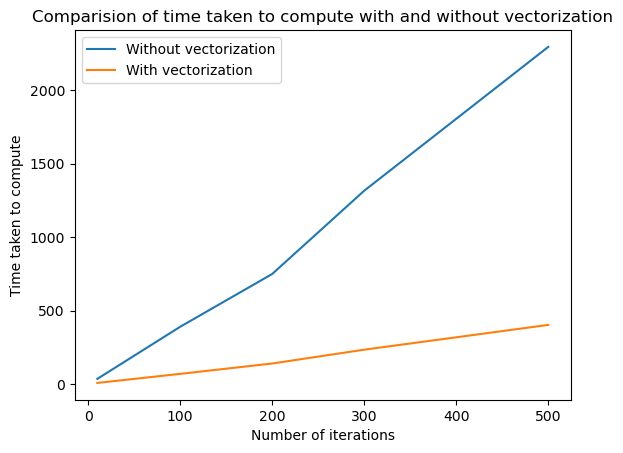

In [120]:
#Time analysis with and without vectorisation

array_of_number_of_iters = [10, 100, 200, 300, 500]
time_taken_without_vectorization = []
time_taken_with_vectorization = []
for num_of_iters in array_of_number_of_iters:
    tic()
    for _ in range(0,num_of_iters):
        sampled_labels, sampled_theta = update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams)
    time_to_append = toc()
    time_taken_without_vectorization.append(time_to_append)
    
    tic()
    for _ in range(0,num_of_iters):
        sampled_labels, sampled_theta = vectorized_update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams)
    time_to_append1 = toc()
    time_taken_with_vectorization.append(time_to_append1)
    
plt.plot(array_of_number_of_iters, time_taken_without_vectorization, label='Without vectorization')
plt.plot(array_of_number_of_iters, time_taken_with_vectorization, label='With vectorization')

plt.xlabel('Number of iterations')
plt.ylabel('Time taken to compute')
plt.title('Comparision of time taken to compute with and without vectorization')
plt.legend()

plt.show()

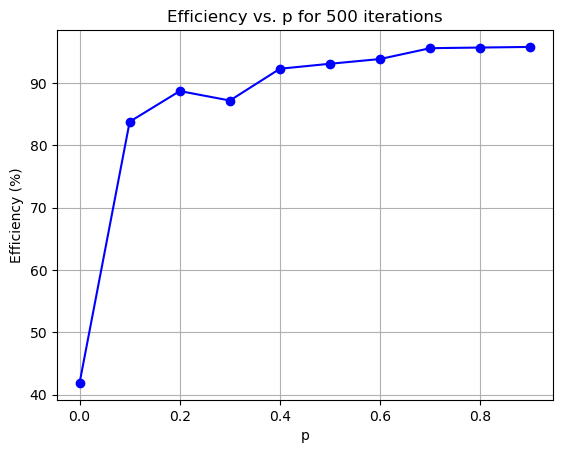

In [29]:
# num of iters = 500
# p=0-> 41.9
# p=0.1->83.8
# p=0.2->88.72
# p=0.3->87.2
# p=0.4->92.3
# p=0.5->93.1
# p=0.6->93.86
# p=0.7->95.6
# p=0.8->95.7
# p=0.9->95.8

#The data is generated by running the vectorized function for the below percentage of data documents.
p_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
efficiency_values = [41.9, 83.8, 88.72, 87.2, 92.3, 93.1, 93.86, 95.6, 95.7, 95.8]

plt.plot(p_values, efficiency_values, marker = 'o', color = 'b', linestyle = '-')

plt.xlabel('p')
plt.ylabel('Efficiency (%)')
plt.title('Efficiency vs. p for 500 iterations')

plt.grid(True)

plt.show()

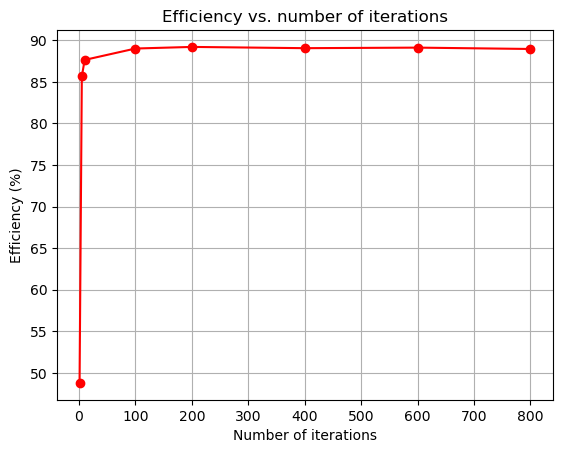

In [91]:
no_of_iters_array = [1, 4, 5, 90, 100, 200, 200, 200]
efficiency = []
for i in no_of_iters_array:
    no_of_iters = i
    for _ in range(0,no_of_iters):
        sampled_labels, sampled_theta = vectorized_update_gibbs_sampling(sampled_labels, sampled_theta, sample_mails, count_label_word_freqs, count_spams_hams)
        
    correct_sample = 0
    
    for i in range(n,no_of_mails):
        if sampled_labels[i-n] == 0 and labels[i] == 'ham' or sampled_labels[i-n] == 1 and labels[i] == 'spam':
            correct_sample += 1
    
    efficiency.append((correct_sample/(no_of_mails-n))*100)
                      

x_axis = [1, 5, 10, 100, 200 , 400, 600, 800]
            
plt.plot(x_axis, efficiency, marker = 'o', color = 'r', linestyle = '-')

plt.xlabel('Number of iterations')
plt.ylabel('Efficiency (%)')
plt.title('Efficiency vs. number of iterations')

plt.grid(True)

plt.show()